# This notebook is part of the Coursera capstone project on accident prevention

### Table of contents

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#ref1">Business understanding</a></li>
        <li><a href="#ref2">Data understanding</a></li>
        <li><a href="#ref3">Data preparation</a></li>
        <li><a href="#ref3">Modelling</a></li>
        <li><a href="#ref3">Evaluation</a></li>
    </ol>
</div>
<br>

## Importing libraries

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from pandas import DataFrame
%matplotlib inline

<a id="ref1"></a>

# Business understanding

The aim of this case study is to asses the
1. Severity of the road accident
    1. Property damage
    2. Injury


2. Causes of accident  
   
   
This is calculated by analysing data of crashes since 2004 across 37 parameters.

<a id="ref2"></a>
# Data understanding

### Loading the dataset

In [17]:
df = pd.read_csv("https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv")
print("No. of (rows, columns) = ", df.shape )
pd.set_option('display.max_columns', None)
df.head(15)

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


No. of (rows, columns) =  (194673, 38)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE.1,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,5TH AVE NE AND NE 103RD ST,,NaN,2,Injury Collision,Angles,2,0,0,2,2013/03/27 00:00:00+00,3/27/2013 2:54:00 PM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Overcast,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,NaN,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,2006/12/20 00:00:00+00,12/20/2006 6:55:00 PM,Mid-Block (not related to intersection),16,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...",NaN,0,Raining,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST,NaN,NaN,1,Property Damage Only Collision,Parked Car,4,0,0,3,2004/11/18 00:00:00+00,11/18/2004 10:20:00 AM,Mid-Block (not related to intersection),14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,0,Overcast,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,2ND AVE BETWEEN MARION ST AND MADISON ST,,NaN,1,Property Damage Only Collision,Other,3,0,0,3,2013/03/29 00:00:00+00,3/29/2013 9:26:00 AM,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,SWIFT AVE S AND SWIFT AV OFF RP,NaN,NaN,2,Injury Collision,Angles,2,0,0,2,2004/01/28 00:00:00+00,1/28/2004 8:04:00 AM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,0,Raining,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N
5,1,-122.387598,47.690575,6,320840,322340,E919477,Matched,Intersection,36974.0,24TH AVE NW AND NW 85TH ST,,NaN,1,Property Damage Only Collision,Angles,2,0,0,2,2019/04/20 00:00:00+00,4/20/2019 5:42:00 PM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
6,1,-122.338485,47.618534,7,83300,83300,3282542,Matched,Intersection,29510.0,DENNY WAY AND WESTLAKE AVE,NaN,NaN,1,Property Damage Only Collision,Angles,2,0,0,2,2008/12/09 00:00:00+00,12/9/2008,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,0,Raining,Wet,Daylight,NaN,8344002.0,NaN,10,Entering at angle,0,0,N
7,2,-122.320780,47.614076,9,330897,332397,EA30304,Matched,Intersection,29745.0,BROADWAY AND E PIKE ST,,NaN,2,Injury Collision,Cycles,3,0,1,1,2020/04/15 00:00:00+00,4/15/2020 5:47:00 PM,At Intersection (intersection related),51,PEDALCYCLIST STRUCK MOTOR VEHICLE FRONT END AT...,NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,5,Vehicle Strikes Pedalcyclist,6855,0,N
8,1,-122.335930,47.611904,10,63400,63400,2071243,Matched,Block,NaN,PINE ST BETWEEN 5TH AVE AND 6TH AVE,NaN,NaN,1,Property Damage Only Collision,Parked Car,2,0,0,2,2006/06/15 00:00:00+00,6/15/2006 1:00:00 PM,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,0,Clear,Dry,Daylight,NaN,6166014.0,NaN,32,One parked--one moving,0,0,N
9,2,-122.384700,47.528475,12,58600,58600,2072105,Matched,Intersection,34679.0,41ST AVE SW AND SW THISTLE ST,NaN,NaN,2,Injury Collision,Angles,2,0,0,2,2006/03/20 00:00:00+00,3/20/2006 3:49:00 PM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK M

### Description of attributes:

| Attribute | Description|Use-case|          
|-----------|------------|-----|
|OBJECTID| ESRI unique identifier|ID|
|Shape|ESRI geometry field |GEO|
|INCKEY|A unique key for the incident|ID|
|COLDETKEY|Secondary key for the incident|ID|
|ADDRTYPE |Alley/block/intersection|GEO, Feature|
|INTKEY|Key that corresponds to the intersection associated with a collision |GEO|
|LOCATION|Description of the general location of the collision |GEO, Feature|
|EXCEPTRSNCODE|||
|EXCEPTRSNDESC|||
|SEVERITYCODE|3—fatality, 2b—serious injury, 2—injury, 1—prop damage, 0—unknown|Outcome|
|SEVERITYDESC|A detailed description of the severity of thecollision |Outcome|
|COLLISIONTYPE|Collision type |Feature|
|PERSONCOUNT|The total number of people involved in thecollision |Feature|
|PEDCOUNT|The number of pedestrians involved in the collision.  |Feature|
|PEDCYLCOUNT |The number of bicycles involved in the collision.  |Feature|
|VEHCOUNT|The number of vehicles involved in the collision.|Feature|
|INJURIES|The number of total injuries in the collision.|Feature|
|SERIOUSINJURIES|The number of serious injuries in the collision. |Feature|
|FATALITIES|The number of fatalities in the collision.|Feature|
|INCDATE|The date of the incident. |Feature|
|INCDTTM|The date and time of the incident|Feature|
|JUNCTIONTYPE|Category of junction at which collision tookplace |Feature|
|SDOT_COLCODE| A code given to the collision by SDOT. |Feature|
|SDOT_COLDESC|A description of the collision corresponding to the collision code. |Feature|
|INATTENTIONIND| Whether or not collision was due to inattention. (Y/N) |Feature|
|UNDERINFL|Whether or not a driver involved was under the influence of drugs or alcohol. |Feature|
|WEATHER|A description of the weather conditions during the time of the collision. |Feature|
|ROADCOND|The condition of the road during the collision. |Feature|
|LIGHTCOND|The light conditions during the collision.|Feature|
|PEDROWNOTGRNT|Whether or not the pedestrian right of way was not granted. (Y/N) |Feature|
|SDOTCOLNUM|A number given to the collision by SDOT. |ID|
|SPEEDING|Whether or not speeding was a factor in the collision. (Y/N) |Feature|
|ST_COLCODE|A code provided by the state that describes the collision. |Feature|
|ST_COLDESC|A description that corresponds to the state’s coding designation.|Feature|
|SEGLANEKEY|A key for the lane segment in which the collision occurred. |Feature|
|CROSSWALKKEY|A key for the crosswalk at which the collision occurred. |Feature|
|HITPARKEDCAR|Whether or not the collision involved hitting aparked car. (Y/N) |Feature|

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 38 columns):
SEVERITYCODE      194673 non-null int64
X                 189339 non-null float64
Y                 189339 non-null float64
OBJECTID          194673 non-null int64
INCKEY            194673 non-null int64
COLDETKEY         194673 non-null int64
REPORTNO          194673 non-null object
STATUS            194673 non-null object
ADDRTYPE          192747 non-null object
INTKEY            65070 non-null float64
LOCATION          191996 non-null object
EXCEPTRSNCODE     84811 non-null object
EXCEPTRSNDESC     5638 non-null object
SEVERITYCODE.1    194673 non-null int64
SEVERITYDESC      194673 non-null object
COLLISIONTYPE     189769 non-null object
PERSONCOUNT       194673 non-null int64
PEDCOUNT          194673 non-null int64
PEDCYLCOUNT       194673 non-null int64
VEHCOUNT          194673 non-null int64
INCDATE           194673 non-null object
INCDTTM           194673 non-null obje

As we can see quite a lot of columns have missing data

In [19]:
k = df.isnull().sum()
k.sort_values(ascending=False, inplace=True)
k = k.to_frame()
k = k.reset_index()
k = k[k[0]!=0]
k.columns = ['Attribute', 'Count of missing data']
k

,Attribute,Count of missing data
0,PEDROWNOTGRNT,190006
1,EXCEPTRSNDESC,189035
2,SPEEDING,185340
3,INATTENTIONIND,164868
4,INTKEY,129603
5,EXCEPTRSNCODE,109862
6,SDOTCOLNUM,79737
7,JUNCTIONTYPE,6329
8,Y,5334
9,X,5334


We need to plug in missing data in the dataset

In [5]:
#0. PEDROWNOTGRNT only Y has been entered. Assuming other values to be N
df['PEDROWNOTGRNT'].fillna("N", inplace=True) 
#1. EXCEPTRSNDESC has unimportant data and we will drop this column
#2. SPEEDING only Y has been entered. Assuming other values to be N
df['SPEEDING'].fillna("N", inplace=True)
#3. INATTENTIONIND only Y has been entered. Assuming other values to be N
df['INATTENTIONIND'].fillna("N", inplace=True)
#4. INTKEY only applicable when ADDRTYPE = Intersection
df['INTKEY'].fillna(0, inplace=True)
#5. EXCEPTRSNCODE has unimportant data and we will drop this column
#6. SDOTCOLUMN is not required and we will drop it

#7. JUNCTIONTYPE unfilled data is unknown; Copying data from same LOCATION and ADDRTYPE AND ST_COLDESC
for i in df.index:
    if(df['JUNCTIONTYPE'][i] =='' ):
        for j in df.index:
             if(df['LOCATION'][i] == df['LOCATION'][j] and df['LOCATION'][j] !=''):
                df['JUNCTIONTYPE'][i] = df['JUNCTIONTYPE'][j] 
                break                
i=0
j=0              

for i in df.index:
    if(df['JUNCTIONTYPE'][i] =='' ):
        for j in df.index:
             if(df['ADDRTYPE'][i] == df['ADDRTYPE'][j] and df['ADDRTYPE'][j] !=''):
                df['JUNCTIONTYPE'][i] = df['JUNCTIONTYPE'][j] 
                break  
i=0
j=0              

for i in df.index:
    if(df['JUNCTIONTYPE'][i] =='' ):
        for j in df.index:
             if(df['ST_COLDESC'][i] == df['ST_COLDESC'][j] and df['ST_COLDESC'][j] !=''):
                df['JUNCTIONTYPE'][i] = df['JUNCTIONTYPE'][j] 
                break                  
                
                
                
#8 & 9 unknown data cannot be substituted
for i in df.index:
    if(df['X'][i] ==''):
        for j in df.index:
             if(df['INTKEY'][i] == df['INTKEY'][j] and df['INTKEY'][j] !=''):
                df['X'][i] = df['X'][j] 
                break

i=0
j=0
#10. Substituting LIGHTCOND for places with same LOCATION and TIME

for i in df.index:
    if(df['LIGHTCOND'][i]==''):
        for j in df.index:
            if(df['LOCATION'][i] == df['LOCATION'][j] and df['INCDTTM'][i] == df['INCDTTM'][j] and df['LOCATION'][j]!='' and df['INCDTTM'][j]!=''):
                df['LIGHTCOND'][i] = df['LIGHTCOND'][j]
    
#11. Assuming same places have same weather
i=0
j=0
for i in df.index:
    if(df['WEATHER'][i]==''):
        for j in df.index:
            if(df['LOCATION'][i] == df['LOCATION'][j] and df['LOCATION'][j]!='' and df['WEATHER'][j]!=''):
                df['WEATHER'][i] = df['WEATHER'][j]

    
#12.  Assuming same places have same road conditiions
i=0
j=0
for i in df.index:
    if(df['ROADCOND'][i]==''):
        for j in df.index:
            if(df['LOCATION'][i] == df['LOCATION'][j] and df['LOCATION'][j]!='' and df['ROADCOND'][j]!=''):
                df['ROADCOND'][i] = df['ROADCOND'][j]
i=0
j=0
for i in df.index:
    if(df['ROADCOND'][i]==''):
        for j in df.index:
            if(df['ADDRTYPE'][i] == df['ADDRTYPE'][j] and df['ADDRTYPE'][j]!='' and df['ROADCOND'][j]!=''):
                df['ROADCOND'][i] = df['ROADCOND'][j]               
                

#13. ST_COLDESC has unimportant data and we will drop this column
#14. COLLISIONTYPE, assuming same type of accidents happen at same address types

i=0
j=0
for i in df.index:
    if(df['COLLISIONTYPE'][i]==''):
        for j in df.index:
            if(df['ST_COLCODE'][i] == df['ST_COLCODE'][j] and df['ST_COLCODE'][j]!=''):
                df['COLLISIONTYPE'][i] = df['COLLISIONTYPE'][j]  

#16. LOCATION - cannot sustitute missing data, filling 0 for the unknown values
df['LOCATION'].fillna(0, inplace=True)

#17. ADDRTYPE, filling 0 for the unknown values
df['UNDERINFL'].fillna('0', inplace=True)

#18. ST_COLCODE, filling 0 for the unknown values
df['ST_COLCODE'].fillna(0, inplace=True)

#df.replace(np.nan, '0', inplace=True)
df.isnull().sum()

df['PEDROWNOTGRNT'].astype('str')
df['HITPARKEDCAR'].astype('str')

df['PEDROWNOTGRNT'].replace('N','0', inplace=True)
df['PEDROWNOTGRNT'].replace('Y','1', inplace=True)
df['HITPARKEDCAR'].replace('N','0', inplace=True)
df['HITPARKEDCAR'].replace('Y','1', inplace=True)
df['UNDERINFL'].replace('N','0', inplace=True)
df['UNDERINFL'].replace('Y','1', inplace=True)
df['SPEEDING'].replace('N','0', inplace=True)
df['SPEEDING'].replace('Y','1', inplace=True)

df['UNDERINFL'] = df['UNDERINFL'].astype('int64')
df['SPEEDING'] = df['SPEEDING'].astype('int64')
df['HITPARKEDCAR'] = df['HITPARKEDCAR'].astype('int64')
df['PEDROWNOTGRNT'] = df['PEDROWNOTGRNT'].astype('int64')

In [6]:
print("Remaining null values")
df.isnull().sum()

Remaining null values


SEVERITYCODE           0
X                   5334
Y                   5334
OBJECTID               0
INCKEY                 0
COLDETKEY              0
REPORTNO               0
STATUS                 0
ADDRTYPE            1926
INTKEY                 0
LOCATION               0
EXCEPTRSNCODE     109862
EXCEPTRSNDESC     189035
SEVERITYCODE.1         0
SEVERITYDESC           0
COLLISIONTYPE       4904
PERSONCOUNT            0
PEDCOUNT               0
PEDCYLCOUNT            0
VEHCOUNT               0
INCDATE                0
INCDTTM                0
JUNCTIONTYPE        6329
SDOT_COLCODE           0
SDOT_COLDESC           0
INATTENTIONIND         0
UNDERINFL              0
WEATHER             5081
ROADCOND            5012
LIGHTCOND           5170
PEDROWNOTGRNT          0
SDOTCOLNUM         79737
SPEEDING               0
ST_COLCODE             0
ST_COLDESC          4904
SEGLANEKEY             0
CROSSWALKKEY           0
HITPARKEDCAR           0
dtype: int64

No Nan datas are remaining in the dataset

### Let us classify the columns into categories

#### Details of accident
1. SEVERITYCODE
2. SEVERITYDESC
3. COLLISIONTYPE
4. SDOT_COLCODE
5. SDOT_COLDESC
6. INCDATE
7. INCDTTM
8. SEGLANEKEY
9. CROSSWALKKEY
10. ST_COLCODE
11. ST_COLDESC

#### Affected
1. PERSONCOUNT
2. PEDCOUNT
3. PEDCYLCOUNT
4. VEHCOUNT
5. PEDROWNOTGRNT
6. HITPARKEDCAR

#### Location factors
1. ADDRTYPE
2. LOCATION
3. JUNCTIONTYPE

#### Human factors
1. INATTENTIONIND
2. UNDERINFL
3. SPEEDING

#### Environmental factors
1. WEATHER
2. ROADCOND
3. LIGHTCOND

Now let us first analyse the details of the accident

### Details of accident

Text(0.5, 1.0, 'Percentage of collisions')

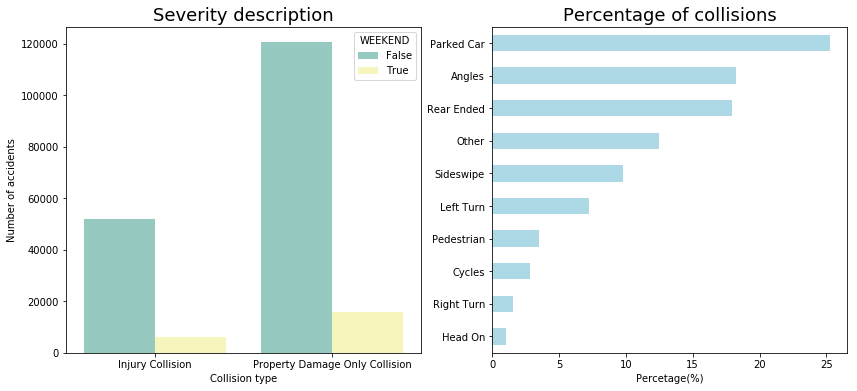

In [72]:
df['DAY'] = pd.to_datetime(df['INCDATE']).dt.dayofweek
df['WEEKEND'] = df['DAY'] > 5 
df['WEEKEND'].rename({'False':'Weekday', 'True':'Weekend'}, inplace=True)

plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
sns.countplot(x="SEVERITYDESC",hue="WEEKEND", data=df, palette="Set3")
plt.title('Severity description', fontsize=18)
plt.xlabel("Collision type")
plt.ylabel("Number of accidents")

plt.subplot(1,2,2)
df['COLLISIONTYPE'].value_counts(normalize=True, ascending=True).mul(100).plot.barh(color='lightblue')
plt.xlabel("Percetage(%)")
plt.title("Percentage of collisions", fontsize=18)

### Analysing the people affected

In [74]:
#plt.figure(figsize=(8,5))
#ax5 = df['PERSONCOUNT'].value_counts( ascending=False).plot.barh()
#plt.title("Person count involved in accidents")

#plt.figure(figsize=(8,5))
#ax0 = df['PEDCOUNT'].value_counts( ascending=False).plot.barh()
#plt.title("Pedestrian count involved in accidents")

#plt.figure(figsize=(8,5))
#ax1 = df['PEDCYLCOUNT'].value_counts( ascending=False).plot.barh()
#plt.title("Cyclists  involved in accidents")

#plt.figure(figsize=(8,5))
#ax2 = df['VEHCOUNT'].value_counts( ascending=False).plot.barh()
#plt.title("Vehicle count involved in accidents")

#plt.figure(figsize=(8,5))
#ax3 = df['PEDROWNOTGRNT'].value_counts( ascending=False).plot.barh()
#plt.title("Pedestrians not granted their way in accidents")

#plt.figure(figsize=(8,5))
#ax4 = df['HITPARKEDCAR'].value_counts( ascending=False, normalize=True).mul(100).plot.barh()
#plt.title("Parked cars involved in accidents")
#plt.show()

### Analyzing location factors

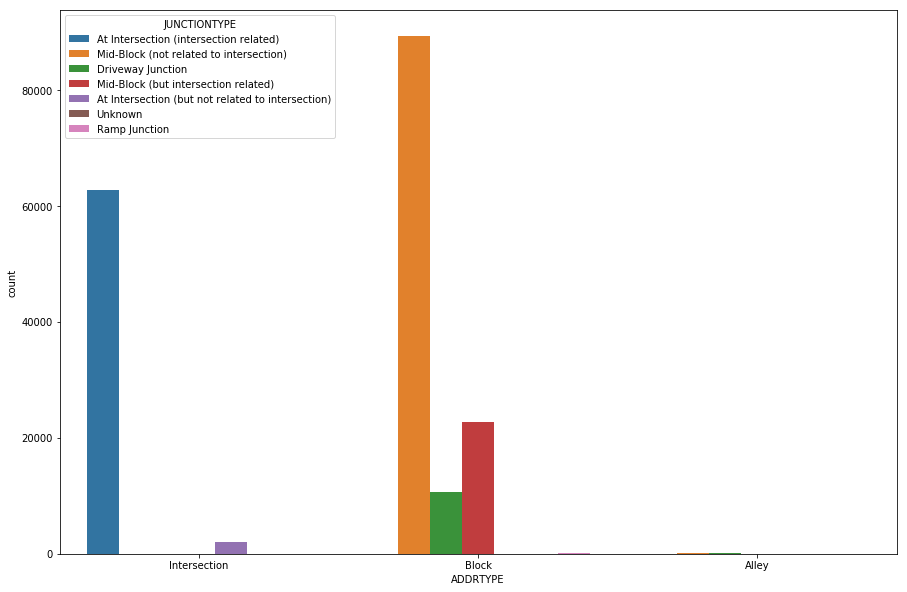

In [81]:
#plt.figure(figsize=(8,5))
#ax0 = df['ADDRTYPE'].value_counts( ascending=False, normalize=True).mul(100).plot.barh()
#plt.title("Address types where accidents occur")
#plt.show()

#plt.figure(figsize=(8,5))
#ax2 = df['JUNCTIONTYPE'].value_counts( ascending=False, normalize=True).mul(100).plot.barh()
#plt.title("Junction types where accidents occur")
#plt.show()
plt.figure(figsize=(15,10))
sns.countplot(x="ADDRTYPE", hue="JUNCTIONTYPE", data=df )

### Analysing human factors

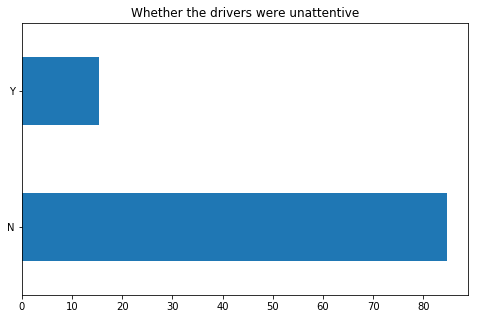

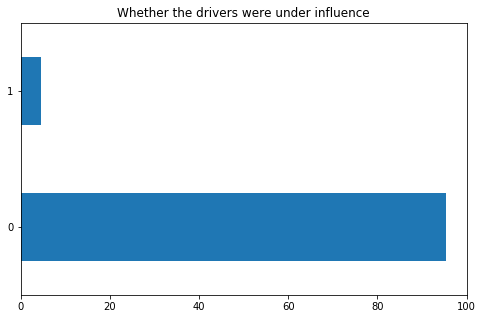

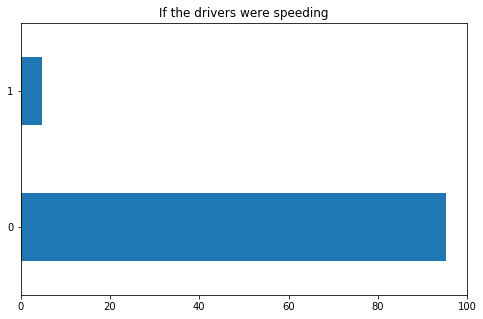

In [10]:
plt.figure(figsize=(8,5))
ax0 = df['INATTENTIONIND'].value_counts( ascending=False, normalize=True).mul(100).plot.barh()
plt.title("Whether the drivers were unattentive")
plt.show()

plt.figure(figsize=(8,5))
ax1 = df['UNDERINFL'].value_counts( ascending=False, normalize=True).mul(100).plot.barh()
plt.title("Whether the drivers were under influence")
plt.show()

plt.figure(figsize=(8,5))
ax2 = df['SPEEDING'].value_counts( ascending=False, normalize=True).mul(100).plot.barh()
plt.title("If the drivers were speeding")
plt.show()

### Analaysing environmental factors

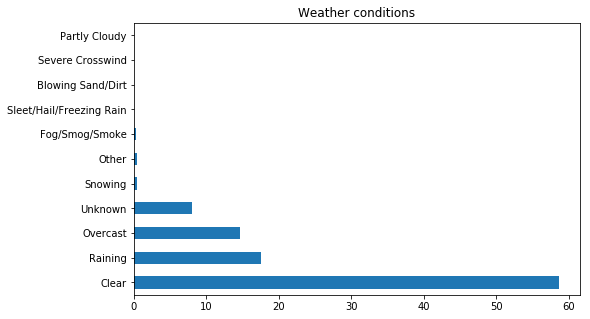

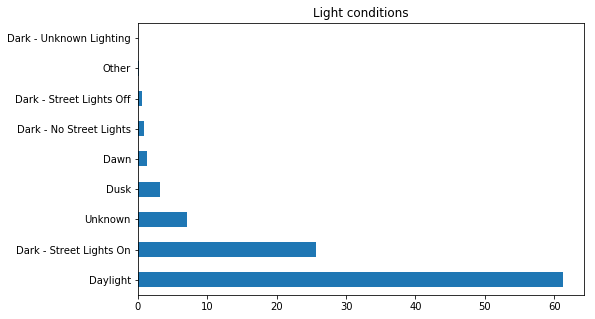

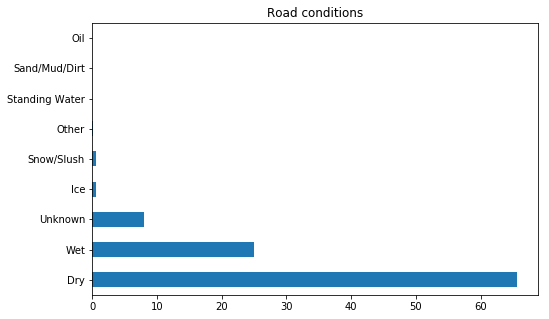

In [11]:
plt.figure(figsize=(8,5))
ax0 = df['WEATHER'].value_counts( ascending=False, normalize=True).mul(100).plot.barh()
plt.title("Weather conditions")
plt.show()

plt.figure(figsize=(8,5))
ax1 = df['LIGHTCOND'].value_counts( ascending=False, normalize=True).mul(100).plot.barh()
plt.title("Light conditions")
plt.show()

plt.figure(figsize=(8,5))
ax2 = df['ROADCOND'].value_counts( ascending=False, normalize=True).mul(100).plot.barh()
plt.title("Road conditions")
plt.show()






# Week 3 assignment begins here

In [164]:
#drop description columns
df_feat = df.drop(['OBJECTID','SEVERITYDESC','INCDATE' ,'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'SDOTCOLNUM', 'SDOT_COLDESC','ST_COLDESC', 'DAY', 'INTKEY',  'EXCEPTRSNCODE', 'EXCEPTRSNDESC','X','Y','SEVERITYCODE.1'],axis=1)

#Splitting ADDRTYPE to Alley, block and intersection
df_feat[['Alley', 'Block', 'Intersection']] = pd.get_dummies(df_feat['ADDRTYPE'])
df_feat.drop(['ADDRTYPE'], axis=1, inplace=True)

#Splitting COLLISIONTYPE
df_feat[pd.get_dummies(df_feat['COLLISIONTYPE']).columns] = pd.get_dummies(df_feat['COLLISIONTYPE'])
df_feat.drop(['COLLISIONTYPE'], axis=1, inplace=True)

#Splitting JUNCTIONTYPE
df_feat[pd.get_dummies(df_feat['JUNCTIONTYPE']).columns] = pd.get_dummies(df_feat['JUNCTIONTYPE'])
df_feat.drop(['JUNCTIONTYPE'], axis=1, inplace=True)

#Splitting WEATHER
df_feat[pd.get_dummies(df_feat['WEATHER']).columns] = pd.get_dummies(df_feat['WEATHER'])
df_feat.drop(['WEATHER'], axis=1, inplace=True)

#Splitting ROADCOND
df_feat[pd.get_dummies(df_feat['ROADCOND']).columns] = pd.get_dummies(df_feat['ROADCOND'])
df_feat.drop(['ROADCOND'], axis=1, inplace=True)

#Splitting LIGHTCOND
df_feat[pd.get_dummies(df_feat['LIGHTCOND']).columns] = pd.get_dummies(df_feat['LIGHTCOND'])
df_feat.drop(['LIGHTCOND'], axis=1, inplace=True)

df_feat['INATTENTIONIND'] = df_feat['INATTENTIONIND'].map({'Y': 1, 'N': 0})
df_feat['UNDERINFL'] = df_feat['UNDERINFL'].map({'Y': 1, 'N': 0, 'nan': 0})
df_feat['SPEEDING'] = df_feat['SPEEDING'].map({'Y': 1, 'N': 0})
df_feat['PEDROWNOTGRNT'] = df_feat['PEDROWNOTGRNT'].map({'Y': 1, 'N': 0})
df_feat['HITPARKEDCAR'] = df_feat['HITPARKEDCAR'].map({'Y': 1, 'N': 0})
df_feat['WEEKEND']  = df_feat['WEEKEND'].astype('int') 

df_feat['UNDERINFL'].unique()
df_feat.corr()

,SEVERITYCODE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,SDOT_COLCODE,INATTENTIONIND,UNDERINFL,PEDROWNOTGRNT,SPEEDING,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,WEEKEND,Alley,Block,Intersection,Angles,Cycles,Head On,Left Turn,Other,Parked Car,Pedestrian,Rear Ended,Right Turn,Sideswipe,At Intersection (but not related to intersection),At Intersection (intersection related),Driveway Junction,Mid-Block (but intersection related),Mid-Block (not related to intersection),Ramp Junction,Unknown,Blowing Sand/Dirt,Clear,Fog/Smog/Smoke,Overcast,Partly Cloudy,Raining,Severe Crosswind,Sleet/Hail/Freezing Rain,Snowing,Dry,Ice,Oil,Sand/Mud/Dirt,Snow/Slush,Standing Water,Wet,Dark - No Street Lights,Dark - Street Lights Off,Dark - Street Lights On,Dark - Unknown Lighting,Dawn,Daylight,Dusk
SEVERITYCODE,1.000000,0.130949,0.246338,0.214218,-0.054686,0.188905,0.046378,NaN,NaN,NaN,0.104276,0.175093,NaN,-0.016296,-0.025790,-0.184745,0.199089,0.095607,0.213271,0.029540,0.057692,-0.005895,-0.304148,0.245441,0.132313,-0.025194,-0.116638,-0.000445,0.201628,0.002190,0.016929,-0.167415,0.001685,-0.151296,-0.001150,0.059436,0.003518,0.014813,0.003333,0.037883,-0.000468,-0.002691,-0.016495,0.066558,-0.012623,0.003015,0.000333,-0.020851,-0.002020,0.040895,-0.015901,-0.006079,-0.000618,0.001063,0.007586,0.087616,0.011773
PERSONCOUNT,0.130949,1.000000,-0.023464,-0.038809,0.380523,-0.128960,0.077435,NaN,NaN,NaN,-0.021383,-0.032258,NaN,0.033959,-0.025228,-0.056826,0.067153,0.092539,-0.039677,0.021879,0.053115,-0.008732,-0.089369,-0.037342,0.139386,0.025008,0.042726,0.000281,0.068239,0.003446,0.044499,-0.071390,0.000160,-0.081919,-0.002450,0.047065,-0.005930,0.011011,0.000586,0.022984,-0.002058,-0.000193,-0.004321,0.053350,-0.013715,-0.004725,-0.006677,-0.002249,-0.008499,0.023244,-0.015269,-0.005750,0.017093,-0.003498,-0.019821,0.054236,0.010907
PEDCOUNT,0.246338,-0.023464,1.000000,-0.016920,-0.261285,0.260393,-0.004315,NaN,NaN,NaN,0.001810,0.565326,NaN,-0.014292,0.003809,-0.140409,0.144936,-0.083188,-0.016255,-0.019212,-0.049346,-0.002036,-0.102872,0.946507,-0.084517,-0.022214,-0.059348,-0.015295,0.149797,-0.012336,-0.052848,-0.089452,-0.002811,-0.039260,-0.001651,0.004113,0.001377,0.001315,-0.000950,0.032832,-0.002124,0.001941,-0.004068,0.006144,-0.006567,-0.003399,-0.001038,-0.004085,-0.002423,0.028607,0.002612,0.002144,0.030356,0.005489,0.010835,-0.001915,0.005413
PEDCYLCOUNT,0.214218,-0.038809,-0.016920,1.000000,-0.253773,0.382521,0.004073,NaN,NaN,NaN,0.453657,0.109820,NaN,-0.022148,-0.006594,-0.080428,0.085377,-0.077584,0.987664,-0.017080,-0.044987,-0.004128,-0.096571,-0.031111,-0.077572,-0.020305,-0.054613,-0.007597,0.087869,0.036267,-0.037892,-0.064170,-0.002852,-0.035000,-0.001067,0.051439,-0.006340,0.001771,-0.000859,-0.027840,-0.001922,-0.002813,-0.010702,0.057838,-0.009110,-0.003075,-0.000202,-0.010497,-0.000335,-0.029357,-0.003688,-0.001977,-0.031864,0.002807,0.010615,0.051020,0.007773
VEHCOUNT,-0.054686,0.380523,-0.261285,-0.253773,1.000000,-0.365814,0.076277,NaN,NaN,NaN,-0.122941,-0.200526,NaN,0.004562,-0.024622,0.078133,-0.073548,0.114396,-0.252753,0.033492,0.057170,-0.001496,0.204188,-0.269287,0.220039,0.020448,0.076444,0.012078,-0.076654,0.002373,0.042699,0.044905,-0.000237,0.026727,0.002610,0.102743,-0.001949,0.029365,0.000636,0.021132,-0.003606,-0.000692,0.006079,0.120795,-0.007794,-0.005806,-0.008735,0.003243,-0.011019,0.029134,-0.004069,-0.000210,0.014354,-0.005554,-0.005116,0.126593,0.012940
SDOT_COLCODE,0.188905,-0.128960,0.260393,0.382521,-0.365814,1.000000,0.029484,NaN,NaN,NaN,0.206835,0.189518,NaN,0.014328,-0.094529,0.069246,-0.019854,-0.183310,0.380783,-0.036358,-0.108362,0.000755,-0.197376,0.255744,-0.007806,-0.034315,-0.079187,0.003958,-0.017673,-0.015521,0.056571,0.106909,0.004969,-0.170880,-0.004128,0.056786,0.010393,0.027457,0.001131,0.052226,0.003716,0.007078,0.008335,0.061371,0.033136,0.013220,0.012077,0.012015,0.016319,0.060388,0.020375,0.012317,0.102308,0.005418,0.026105,0.002540,0.003932
INATTENTIONIND,0.046378,0.077435,-0.004315,